In [1]:
import dask
import dask.dataframe as dd
import math
import pandas as pd
import time
import glob
import os

In [2]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=1, threads_per_worker=4, memory_limit = '4GB')
# explicitly connect to the cluster just created
client = Client(cluster)
# Viewing the client and the cluster
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 4,Total memory: 3.73 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:58700,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 3.73 GiB
Comm: tcp://127.0.0.1:58712,Total threads: 4
Dashboard: http://127.0.0.1:58713/status,Memory: 3.73 GiB
Nanny: tcp://127.0.0.1:58703,


In [3]:
#reading multiple csv files into one dask dataframe
df = dd.read_csv('C:/Users/2130988/Documents/DDA/PRSA_Data_*_*.csv', dtype={'CO': 'float64',
       'NO2': 'float64',
       'O3': 'float64',
       'PM10': 'float64',
       'PM2.5': 'float64',
       'RAIN': 'float64',
       'SO2': 'float64'})
df.head()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin


In [4]:
#checking the number of NA values in all columns
df.isna().sum().compute()

No             0
year           0
month          0
day            0
hour           0
PM2.5       8739
PM10        6449
SO2         9021
NO2        12116
CO         20701
O3         13277
TEMP         398
PRES         393
DEWP         403
RAIN         390
wd          1822
WSPM         318
station        0
dtype: int64

In [5]:
#custom function to change all outlier values to NA; outlier threshold determined from UN report on Beijing air pollution
def change_outliers(pollution):
    pollution["PM10"] = pollution.PM10.mask(pollution.PM10 > 190)
    pollution["SO2"] = pollution.SO2.mask(pollution.SO2 > 150)
    pollution["NO2"] = pollution.NO2.mask(pollution.NO2 > 120)
    pollution["CO"] = pollution.CO.mask(pollution.CO > 1400)
    pollution["O3"] = pollution.O3.mask(pollution.O3 > 205)
    return pollution

In [6]:
#calling the outlier function on the dask dataframe
df = df.map_partitions(change_outliers, meta=df)
df.compute()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35059,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
35060,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
35061,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
35062,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [7]:
#checking that NA values have increased
df.isna().sum().compute()

No              0
year            0
month           0
day             0
hour            0
PM2.5        8739
PM10        66459
SO2          9844
NO2         30130
CO         128027
O3          25025
TEMP          398
PRES          393
DEWP          403
RAIN          390
wd           1822
WSPM          318
station         0
dtype: int64

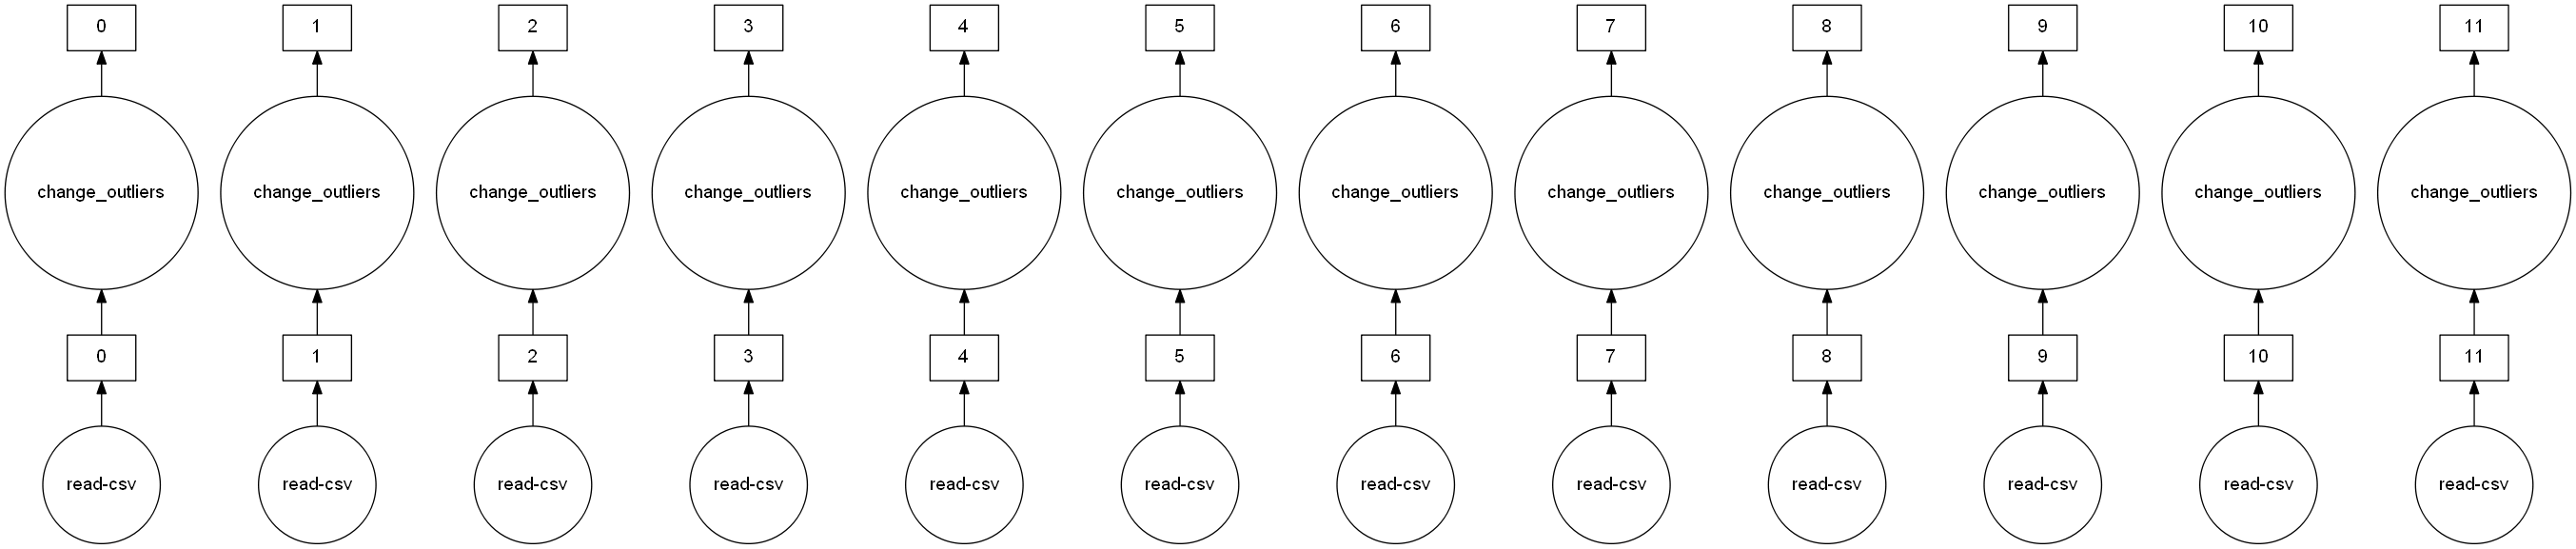

In [8]:
#visualizing how the outlier function was executed using parallel processing for each partition of the dask dataframe
df.visualize()

In [9]:
#creating a grouped dataframe for mean values of each station and month
grouped_df = df.groupby(['station', 'month']).agg({'TEMP': ['mean'], 'PM2.5': ['mean'], 'PM10': ['mean'], 'SO2': ['mean'], 'NO2': ['mean'], 'O3': ['mean'], 'CO': ['mean'], 'PRES': ['mean'], 'DEWP' : ['mean'], 'RAIN' : ['mean'], 'WSPM' : ['mean']}).compute()
grouped_df

TEMP       PM2.5       PM10        SO2        NO2  \
                          mean        mean       mean       mean       mean   
station       month                                                           
Aotizhongxin  1      -1.636747   92.817045  73.544311  33.743594  56.577667   
              2       1.299797   85.840645  63.495264  29.248092  47.598063   
              3       8.403951   99.999384  87.532034  31.170496  57.548410   
              4      15.309271   76.177490  98.179619  16.405318  50.176523   
              5      21.419657   67.340081  89.868388  16.004978  46.631061   
...                        ...         ...        ...        ...        ...   
Wanshouxigong 8      26.941364   55.353770  72.212947   4.199956  41.926413   
              9      21.099595   61.381060  78.092733   6.759432  51.461915   
              10     13.725791   92.642001  77.885062   7.890503  59.761902   
              11      4.878368  105.400316  76.075308  15.670112  58.551858   
              12      0.011559  121.911004  69.534214  29.419682  60.137013   

                            O3          CO         PRES       DEWP      RAIN  \
                          mean        mean         mean       mean      mean   
station       month                                                            
Aotizhongxin  1      27.034153  724.763194  1023.247352 -14.333536  0.000337   
              2      43.174129  614.688249  1021.382380 -12.689856  0.010845   
              3      47.584506  684.540758  1014.972116  -7.177352  0.009073   
              4      63.602911  687.907260  1009.360347   1.170903  0.023542   
              5      78.167066  652.151185  1003.427655   7.710517  0.047413   
...                        ...         ...          ...        ...       ...   
Wanshouxigong 8      78.738880  843.108270  1001.785450  18.989012  0.106788   
              9      52.901309  830.137788  1009.226871  14.037626  0.116986   
              10     27.623705  771.955128  1015.436814   5.753360  0.042977   
              11     18.267377  700.714286  1020.464757  -4.338507  0.015208   
              12     18.779230  662.352941  1023.147614 -11.490860  0.000706   

                         WSPM  
                         mean  
station       month            
Aotizhongxin  1      1.878571  
              2      1.974142  
              3      2.028125  
              4      2.173958  
              5      2.043548  
...                       ...  
Wanshouxigong 8      1.511526  
              9      1.405322  
              10     1.470027  
              11     1.603333  
              12     1.795262  

[144 rows x 11 columns]

In [10]:
#loading the multiple csv files again into a pandas dataframe for easy manipulation based on index which is not possible in dask
files = os.path.join('C:/Users/2130988/Documents/DDA/*.csv')
files = glob.glob(files)

pollution = pd.concat(map(pd.read_csv, files), ignore_index = True)
pollution

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


In [11]:
#calling the outlier function on the pandas dataframe which means no parallel processing takes place
pollution = change_outliers(pollution)
pollution.isna().sum()

No              0
year            0
month           0
day             0
hour            0
PM2.5        8739
PM10        66459
SO2          9844
NO2         30130
CO         128027
O3          25025
TEMP          398
PRES          393
DEWP          403
RAIN          390
wd           1822
WSPM          318
station         0
dtype: int64

In [12]:
#list of numerical columns with NA values
cols = ['TEMP', 'PM2.5', 'PM10', 'SO2', 'NO2', 'O3', 'CO', 'PRES', 'DEWP', 'RAIN', 'WSPM']

In [13]:
#custom function to return mean value from the grouped dataframe based on station, month and column name
def getmean(station, month, col):
    # using the station and month values from the grouped table, we extract the mean
    mean = grouped_df.loc[(station, month)][col]['mean']
    return mean

In [14]:
#custom function to impute values for NAs in the column list by using the custom getmean function
def clean_data(poll): 
    # first iterate through column names, and make nested loops for the values inside each column
    for col in cols:
        # x is index, c is the value in that location
        for x, c in poll[col].iteritems():
            # check if value is null / NA 
            if pd.isnull(c):
                # if it is null then get station and month
                station = poll.loc[x, 'station']
                month = poll.loc[x, 'month']
                # call the function getmean() to get the mean from the grouped table.
                mean = getmean(station, month, col)
                # change value from Null to mean.
                poll.loc[x, col] = mean
    return poll

In [15]:
#creating a grouped dataframe of wind direction's mode values for each station and month
pollution_mode = pollution.groupby(['station', 'month'])['wd'].agg(pd.Series.mode)
pollution_mode

station        month
Aotizhongxin   1         NE
               2         NE
               3         NE
               4         SW
               5         SW
                       ... 
Wanshouxigong  8         SW
               9         NE
               10        NE
               11       WNW
               12       WNW
Name: wd, Length: 144, dtype: object

In [16]:
#custom function to return wind direction mode value from the grouped dataframe based on station and month
def getmode(station, month):
    mode = pollution_mode.loc[(station, month)]
    return mode

In [17]:
#custom function to impute values for NAs in the wind direction column by using the custom getmode function
def clean_wd(poll):
    # x is index, and c is the value in that location, loop through the column wd
    for x, c, in poll['wd'].iteritems():
        # check if value is null
        if pd.isnull(c):
            #get station and month if the value is null
            station = poll.loc[x, 'station']
            month = poll.loc[x, 'month']
            # call get mode function
            mode = getmode(station, month)
            # replace NA with mode.
            poll.loc[x, 'wd'] = mode
    return poll

In [18]:
#creating a dask dataframe from the pandas dataframe to store the final cleaned dataset
cleaned_pollution = dd.from_pandas(pollution, npartitions=12)
cleaned_pollution

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
npartitions=12,,,,,,,,,,,,,,,,,,
0,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,object,float64,object
35064,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385704,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420767,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [19]:
#calling the clean_data function on the final dask dataframe using parallel processing for each partition
cleaned_pollution = cleaned_pollution.map_partitions(clean_data, meta=cleaned_pollution)
cleaned_pollution.compute()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


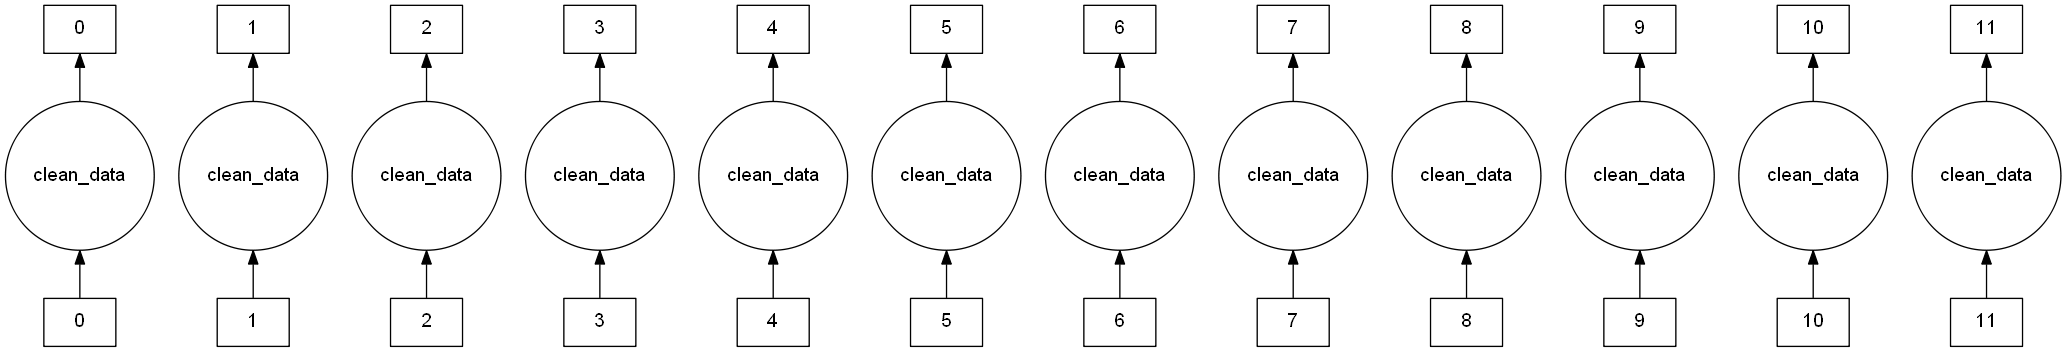

In [20]:
#visualizing how the clean_data function was executed using parallel processing for each partition of the dask dataframe
cleaned_pollution.visualize()

In [21]:
#checking that there are now no NA values in the numerical columns
cleaned_pollution.isna().sum().compute()

No            0
year          0
month         0
day           0
hour          0
PM2.5         0
PM10          0
SO2           0
NO2           0
CO            0
O3            0
TEMP          0
PRES          0
DEWP          0
RAIN          0
wd         1822
WSPM          0
station       0
dtype: int64

In [22]:
#calling the clean_wd function on the final dask dataframe using parallel processing for each partition
cleaned_pollution = cleaned_pollution.map_partitions(clean_wd, meta=cleaned_pollution)
cleaned_pollution.compute()

,No,year,month,day,hour,PM2.5,PM10,SO2,NO2,CO,O3,TEMP,PRES,DEWP,RAIN,wd,WSPM,station
0,1,2013,3,1,0,4.0,4.0,4.0,7.0,300.0,77.0,-0.7,1023.0,-18.8,0.0,NNW,4.4,Aotizhongxin
1,2,2013,3,1,1,8.0,8.0,4.0,7.0,300.0,77.0,-1.1,1023.2,-18.2,0.0,N,4.7,Aotizhongxin
2,3,2013,3,1,2,7.0,7.0,5.0,10.0,300.0,73.0,-1.1,1023.5,-18.2,0.0,NNW,5.6,Aotizhongxin
3,4,2013,3,1,3,6.0,6.0,11.0,11.0,300.0,72.0,-1.4,1024.5,-19.4,0.0,NW,3.1,Aotizhongxin
4,5,2013,3,1,4,3.0,3.0,12.0,12.0,300.0,72.0,-2.0,1025.2,-19.5,0.0,N,2.0,Aotizhongxin
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
420763,35060,2017,2,28,19,11.0,32.0,3.0,24.0,400.0,72.0,12.5,1013.5,-16.2,0.0,NW,2.4,Wanshouxigong
420764,35061,2017,2,28,20,13.0,32.0,3.0,41.0,500.0,50.0,11.6,1013.6,-15.1,0.0,WNW,0.9,Wanshouxigong
420765,35062,2017,2,28,21,14.0,28.0,4.0,38.0,500.0,54.0,10.8,1014.2,-13.3,0.0,NW,1.1,Wanshouxigong
420766,35063,2017,2,28,22,12.0,23.0,4.0,30.0,400.0,59.0,10.5,1014.4,-12.9,0.0,NNW,1.2,Wanshouxigong


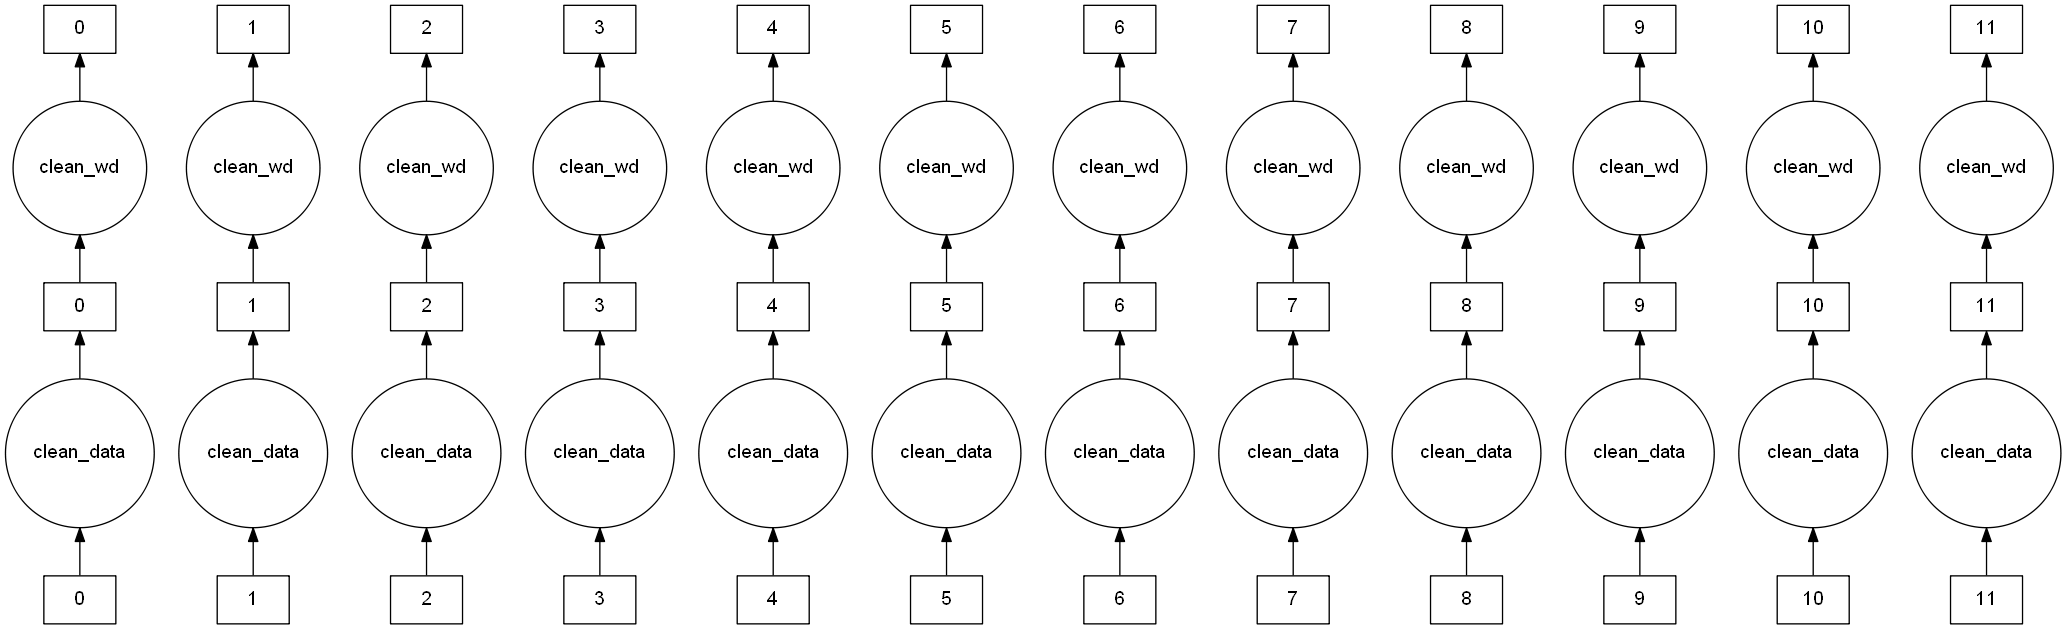

In [23]:
#visualizing how the clean_wd function was executed using parallel processing for each partition of the dask dataframe
cleaned_pollution.visualize()

In [24]:
#checking that there are now no NA values in the wind direction column / all the columns
cleaned_pollution.isna().sum().compute()

No         0
year       0
month      0
day        0
hour       0
PM2.5      0
PM10       0
SO2        0
NO2        0
CO         0
O3         0
TEMP       0
PRES       0
DEWP       0
RAIN       0
wd         0
WSPM       0
station    0
dtype: int64

In [ ]:
#exporting the cleaned dataframe as multiple csv files for further processing in R
cleaned_pollution.to_csv('C:/Users/2130988/Documents/DDA/cleandata/export-*.csv')